<a href="https://colab.research.google.com/github/Allexxandr/data-analytics-project-100/blob/main/charts_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import requests
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
import seaborn as sns
from dotenv import load_dotenv


In [6]:
def preparing_data():
    """
    Подготавливает данные из API о визитах и регистрациях.

    Загружает переменные окружения, получает данные через API,
    обрабатывает визиты (удаляет ботов, оставляет только последние визиты),
    обрабатывает регистрации и возвращает подготовленные DataFrame'ы.

    Возвращает:
        tuple: (visits_df, regs_df) - обработанные DataFrame'ы с данными о визитах и регистрациях
    """

    load_dotenv()

    DATE_BEGIN = os.getenv('DATE_BEGIN')
    DATE_END = os.getenv('DATE_END')
    API_URL = os.getenv('API_URL')
    # Получаем данные по визитам
    rsp_visits = requests.get(
        f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
    visits_data = rsp_visits.json()
    visits_df = pd.DataFrame(visits_data)

    # Обработка данных о визитах
    visits_df = visits_df[visits_df['user_agent'] != 'bot']
    visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
    visits_df = visits_df.sort_values(by=['datetime']).drop_duplicates(
        subset=['visit_id'], keep='last')
    visits_df['date_group'] = visits_df['datetime'].dt.date

    # Получаем данные по регистрациям
    rsp_regs = requests.get(f'{API_URL}/registrations',
                            params={'begin': DATE_BEGIN, 'end': DATE_END})
    data_regs = rsp_regs.json()
    regs_df = pd.DataFrame(data_regs)

    # Обработка данных о регистрациях
    regs_df['datetime'] = pd.to_datetime(regs_df['datetime'])
    regs_df['date_group'] = regs_df['datetime'].dt.date

    return visits_df, regs_df

In [7]:
def merge_dataframes():
    """
    Объединяет датафреймы с данными о посещениях, регистрациях и рекламе.

    Выполняет следующие действия:
    1. Группировку данных по платформам и датам
    2. Расчет конверсии
    3. Добавление данных о рекламе
    4. Сохранение результатов в JSON файлы

    Параметры:
        None

    Возвращает:
        pd.DataFrame: результирующий DataFrame с объединенными данными

    """
    visits_df, regs_df = preparing_data()
    # Группировка данных по платформам и датам
    regs_grouped = regs_df.groupby(
        ['date_group', 'platform']).size().reset_index(name='registrations')
    visits_grouped = visits_df.groupby(
        ['date_group', 'platform']).size().reset_index(name='visits')

    # Конвертация типов
    regs_grouped['date_group'] = pd.to_datetime(regs_grouped['date_group'])
    visits_grouped['date_group'] = pd.to_datetime(visits_grouped['date_group'])

    # Объединение данных с учетом конверсии
    merged_df = pd.merge(regs_grouped, visits_grouped,
                         on=['date_group', 'platform'],
                         how='inner')

    # Приведение к целочисленному типу
    merged_df['registrations'] = merged_df['registrations'].astype(int)
    merged_df['visits'] = merged_df['visits'].astype(int)

    # Расчет конверсии
    merged_df['conversion'] = np.where(
        merged_df['visits'] == 0, 0,
        merged_df['registrations'] / merged_df['visits'] * 100
    )

    # Выбор необходимых колонок
    merged_df = merged_df[['date_group', 'platform', 'visits',
                          'registrations', 'conversion']]

    # Сохранение промежуточных данных
    merged_df.to_json('./conversion.json')

    # Добавление данных по рекламе
    ads_df = pd.read_csv('ads.csv')
    ads_df['date'] = pd.to_datetime(ads_df['date'])
    ads_df['date_group'] = ads_df['date'].dt.date

    # Группировка данных по рекламе
    ads_grouped = ads_df.groupby(['date_group', 'utm_campaign'])[
        'cost'].sum().reset_index()
    ads_grouped['date_group'] = pd.to_datetime(ads_grouped['date_group'])

    # Объединение с данными о конверсии
    result_df = pd.merge(
        merged_df.assign(date_group=merged_df['date_group']),
        ads_grouped,
        on='date_group',
        how='left'
    )

    # Заполнение пропущенных значений
    result_df.fillna({'cost': 0, 'utm_campaign': 'none'}, inplace=True)

    # Сохранение финального результата
    result_df.to_json('ads.json', orient='records')

    return result_df


In [8]:
def charts():
    """
    Создает все необходимые визуализации данных.

    Функция создает следующие графики:
    1. Общие визиты по дням
    2. Визиты по платформам (стековый график)
    3. Общие регистрации по дням
    4. Регистрации по платформам (стековый график)
    5. Общая конверсия
    6. Конверсия по платформам
    7. Стоимость рекламных кампаний
    8. Визиты и регистрации с выделением рекламных кампаний

    Все графики сохраняются в директории 'charts' с высоким разрешением (dpi=300).
    """
    result_df = merge_dataframes()
    # Создаем директорию для сохранения графиков
    chart_dir = 'charts'
    if not os.path.exists(chart_dir):
        os.makedirs(chart_dir)

    result_df['date_group'] = pd.to_datetime(result_df['date_group'], unit='ms')
    result_df['week_group'] = result_df['date_group'].dt.to_period('W')

    # График общих визитов по неделям
    weekly_visits = result_df.groupby('week_group')['visits'].sum().reset_index()
    weekly_visits['week_start_date'] = weekly_visits['week_group'].apply(lambda x: x.start_time.strftime('%Y-%m-%d'))

    plt.figure(figsize=(45, 15))
    plt.bar(weekly_visits['week_start_date'], weekly_visits['visits'],
            color='lightblue', label='Weekly Visits')

    plt.title('Total Weekly Visits', fontsize=14)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Visits', fontsize=12)

    # Настройка меток оси X с новым форматированием
    plt.xticks(rotation=45, ha='right', fontsize=10)

    plt.grid(axis='y', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('./charts/total_weekly_visits.png', dpi=300, bbox_inches='tight')
    # График визитов по платформам (стековый)
    result_df_no_bot = result_df[result_df['platform'] != 'bot']
    stacked_data_visits = result_df_no_bot.pivot_table(
        index='week_group',
        columns='platform',
        values='visits',
        aggfunc='sum',
        fill_value=0
    )

    # Создаем список уникальных дат начала недели
    unique_week_starts = sorted(stacked_data_visits.index.map(lambda x: x.start_time.strftime('%Y-%m-%d')))

    plt.figure(figsize=(22, 10))
    stacked_data_visits.plot(kind='bar', stacked=True, ax=plt.gca())

    # Настраиваем метки осей и заголовок
    plt.xlabel('Week')
    plt.ylabel('Visits')
    plt.title('Weekly Visits by Platform')

    # Обновляем метки оси X
    plt.xticks(range(len(unique_week_starts)), unique_week_starts, rotation=45, ha='right')

    # Добавляем сетку и легенду
    plt.grid(alpha=0.5)
    plt.legend(title='Platform')

    # Применяем компактную форму
    plt.tight_layout()
    plt.savefig('./charts/weekly_visits_by_platform.png')

    # График общих регистраций по неделям
    weekly_registrations = result_df.groupby('week_group')['registrations'].sum().reset_index()
# Создаем новый столбец с форматированной датой начала недели
    weekly_registrations['week_start_date'] = weekly_registrations['week_group'].apply(lambda x: x.start_time.strftime('%Y-%m-%d'))

    plt.figure(figsize=(45, 15))
    plt.bar(weekly_registrations['week_start_date'], weekly_registrations['registrations'],
            color='lightblue', label='Weekly Registrations')

    plt.title('Total Weekly Registrations', fontsize=14)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Registrations', fontsize=12)

    # Настройка меток оси X с новым форматированием
    plt.xticks(rotation=45, ha='right', fontsize=10)

    plt.grid(axis='y', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('./charts/total_weekly_registrations.png', dpi=300, bbox_inches='tight')

    # График регистраций по платформам (стековый)
    stacked_data_registrations = result_df_no_bot.pivot_table(
        index='week_group',
        columns='platform',
        values='registrations',
        aggfunc='sum',
        fill_value=0
    )

    # Создаем список уникальных дат начала недели
    unique_week_starts = sorted(stacked_data_registrations.index.map(lambda x: x.start_time.strftime('%Y-%m-%d')))

    plt.figure(figsize=(22, 10))
    stacked_data_registrations.plot(kind='bar', stacked=True, ax=plt.gca())

    # Настраиваем метки осей и заголовок
    plt.xlabel('Week')
    plt.ylabel('Registrations')
    plt.title('Weekly Registrations by Platform')

    # Обновляем метки оси X
    plt.xticks(range(len(unique_week_starts)), unique_week_starts, rotation=45, ha='right')

    # Добавляем сетку и легенду
    plt.grid(alpha=0.5)
    plt.legend(title='Platform')

    # Применяем компактную форму
    plt.tight_layout()
    plt.savefig('./charts/weekly_registrations_by_platform.png')


    # График еженедельной конверсии
    weekly_conversion_no_bot = (
        result_df_no_bot.groupby('date_group')
        .apply(lambda x: x['registrations'].sum() / x['visits'].sum() * 100)
        .resample('W-MON')  # Группировка по неделям с понедельником как первым днём
        .mean()
        .reset_index(name='conversion_rate')
    )

    plt.figure(figsize=(14, 6))
    plt.plot(weekly_conversion_no_bot['date_group'], weekly_conversion_no_bot['conversion_rate'],
            marker='o', color='blue', label='Weekly Conversion Rate')

    for x, y in zip(weekly_conversion_no_bot['date_group'],
                    weekly_conversion_no_bot['conversion_rate']):
        plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)

    # Создаём тикеты для каждой недели

    DATE_BEGIN = os.getenv('DATE_BEGIN')
    DATE_END = os.getenv('DATE_END')

    # Создание диапазона дат
    weekly_ticks = pd.date_range(
    start=DATE_BEGIN,
    end=DATE_END,
    freq='W-MON'
    )



    plt.title('Weekly Conversion', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Conversion (%)', fontsize=12)
    plt.xticks(ticks=weekly_ticks, labels=weekly_ticks.strftime('%Y-%m-%d'),
              rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('./charts/weekly_conversion.png',
                dpi=300, bbox_inches='tight')


    # График еженедельной конверсии по платформам
    result_df_no_bot = result_df[result_df['platform'] != 'bot']
    platforms_no_bot = result_df_no_bot['platform'].unique()

    for platform in platforms_no_bot:
        plt.figure(figsize=(14, 6))

        # Получаем данные для текущей платформы
        platform_data = result_df_no_bot[result_df_no_bot['platform'] == platform]

        # Расчёт еженедельной конверсии
        weekly_conversion = (
            platform_data.groupby('date_group')[['registrations', 'visits']]  # Явно указываем колонки
            .apply(lambda x: (x['registrations'].sum() / x['visits'].sum() * 100), include_groups=False)  # Добавляем include_groups=False
            .resample('W-MON')  # Группировка по неделям
            .mean()
            .reset_index(name='conversion_rate')  # Явно указываем имя колонки
        )

        # Строим график
        plt.plot(weekly_conversion['date_group'], weekly_conversion['conversion_rate'],
                marker='o', color='blue', label=f'Weekly Conversion ({platform})')

        # Добавляем значения над точками
        for x, y in zip(weekly_conversion['date_group'], weekly_conversion['conversion_rate']):
            plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)

        # Настраиваем оси времени
         # Создание диапазона дат
        weekly_ticks = pd.date_range(
        start=DATE_BEGIN,
        end=DATE_END,
        freq='W-MON'
        )

        # Настраиваем оформление графика
        plt.title(f'Weekly Conversion {platform.capitalize()}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Conversion (%)', fontsize=12)
        plt.xticks(ticks=weekly_ticks, labels=weekly_ticks.strftime('%Y-%m-%d'),
                  rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='both', linestyle='-', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()

        # Сохраняем график
        plt.savefig(f'./charts/weekly_conversion_by_platform_{platform}.png',
                    dpi=300, bbox_inches='tight')

    # Группировка по неделям и суммирование затрат
    weekly_cost = result_df.groupby(result_df['date_group'].dt.to_period('W'))['cost'].sum().reset_index()
    weekly_cost.columns = ['date_group', 'cost']
    weekly_cost['date_group'] = weekly_cost['date_group'].apply(lambda x: x.to_timestamp())

    # Создание графика
    plt.figure(figsize=(45, 15))
    plt.plot(weekly_cost['date_group'], weekly_cost['cost'], marker='o',
            color='lightgreen', label='Weekly Advertising Cost')
    for x, y in zip(weekly_cost['date_group'], weekly_cost['cost']):
        plt.text(x, y + 0.5, f"{y:.2f} RUB", ha='center', fontsize=9)
    plt.title('Aggregated Ad Campaign Costs (by week)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cost (RUB)', fontsize=12)
    plt.xticks(weekly_cost['date_group'], weekly_cost['date_group'].dt.strftime('%Y-%m-%d'),
              rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.grid(axis='x', linestyle='-', alpha=0.7)
    plt.tight_layout()
    plt.savefig('./charts/aggregated_ad_campaign_costs_weekly.png',
                dpi=300, bbox_inches='tight')


    # Создание группировки по неделям
    weekly_visits = result_df.groupby('week_group')['visits'].sum().reset_index()
    weekly_visits['week_start_date'] = weekly_visits['week_group'].apply(lambda x: x.start_time.strftime('%Y-%m-%d'))

    # График посещений по неделям с выделением рекламных кампаний
    plt.figure(figsize=(45, 15))

    # Расчет среднего значения посещений по неделям
    mean_weekly_visits = weekly_visits['visits'].mean()

    # Построение линии посещений по неделям
    plt.plot(weekly_visits['week_start_date'], weekly_visits['visits'],
            marker='o', color='blue', label='Weekly Visits')

    # Добавление горизонтальной линии со средним значением
    plt.axhline(mean_weekly_visits, color='red', linestyle='--', linewidth=1.5,
              label='Average Weekly Visits')

    # Получаем уникальные кампании и создаем словарь цветов
    campaigns = result_df['utm_campaign'].unique()
    campaign_colors = {campaign: color for campaign, color in zip(campaigns, cm.tab20.colors)}

    # Отображение кампаний на графике
    for campaign in campaigns:
        if campaign != 'none':
            campaign_data = result_df[result_df['utm_campaign'] == campaign]
            if not campaign_data.empty:
                start_date = campaign_data['date_group'].min()
                end_date = campaign_data['date_group'].max()

                # Находим соответствующие недели для кампании
                campaign_weeks = weekly_visits[
                    (weekly_visits['week_start_date'] >= str(start_date)) &
                    (weekly_visits['week_start_date'] <= str(end_date))
                ]

                # Если есть недели в периоде кампании
                if not campaign_weeks.empty:
                    plt.axvspan(
                        campaign_weeks['week_start_date'].iloc[0],
                        campaign_weeks['week_start_date'].iloc[-1],
                        alpha=0.3,
                        color=campaign_colors[campaign],
                        label=f'Campaign: {campaign}'
                    )

    plt.title('Weekly Visits during marketing active periods', fontsize=14)
    plt.xlabel('Week Starting Date', fontsize=12)
    plt.ylabel('Visits', fontsize=12)

    # Форматирование оси X с интервалом в одну неделю
    weeks_to_show = len(weekly_visits) // 5  # Показываем каждую пятую неделю
    plt.xticks(range(0, len(weekly_visits), weeks_to_show),
              weekly_visits['week_start_date'][::weeks_to_show].tolist(),
              rotation=45, fontsize=10)

    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()

    # Сохранение графика
    plt.savefig('./charts/weekly_visits_during_marketing_active_days.png',
                dpi=300, bbox_inches='tight')

    # Создание группировки по неделям
    weekly_registrations = result_df.groupby('week_group')['registrations'].sum().reset_index()
    weekly_registrations['week_start_date'] = weekly_registrations['week_group'].apply(lambda x: x.start_time.strftime('%Y-%m-%d'))

    # График регистраций по неделям с выделением рекламных кампаний
    plt.figure(figsize=(45, 15))

    # Расчет среднего значения регистраций по неделям
    mean_weekly_registrations = weekly_registrations['registrations'].mean()

    # Построение линии регистраций по неделям
    plt.plot(weekly_registrations['week_start_date'], weekly_registrations['registrations'],
            marker='o', color='green', label='Weekly Registrations')

    # Добавление горизонтальной линии со средним значением
    plt.axhline(mean_weekly_registrations, color='red', linestyle='--', linewidth=1.5,
              label='Average Weekly Registrations')

    # Получаем уникальные кампании и создаем словарь цветов
    campaigns = result_df['utm_campaign'].unique()
    campaign_colors = {campaign: color for campaign, color in zip(campaigns, cm.tab20.colors)}

    # Отображение кампаний на графике
    for campaign in campaigns:
        if campaign != 'none':
            campaign_data = result_df[result_df['utm_campaign'] == campaign]
            if not campaign_data.empty:
                start_date = campaign_data['date_group'].min()
                end_date = campaign_data['date_group'].max()

                # Находим соответствующие недели для кампании
                campaign_weeks = weekly_registrations[
                    (weekly_registrations['week_start_date'] >= str(start_date)) &
                    (weekly_registrations['week_start_date'] <= str(end_date))
                ]

                # Если есть недели в периоде кампании
                if not campaign_weeks.empty:
                    plt.axvspan(
                        campaign_weeks['week_start_date'].iloc[0],
                        campaign_weeks['week_start_date'].iloc[-1],
                        alpha=0.3,
                        color=campaign_colors[campaign],
                        label=f'Campaign: {campaign}'
                    )

    plt.title('Weekly Registrations during marketing active periods', fontsize=14)
    plt.xlabel('Week Starting Date', fontsize=12)
    plt.ylabel('Registrations', fontsize=12)

    # Форматирование оси X с интервалом в одну неделю
    weeks_to_show = len(weekly_registrations) // 5  # Показываем каждую пятую неделю
    plt.xticks(range(0, len(weekly_registrations), weeks_to_show),
              weekly_registrations['week_start_date'][::weeks_to_show].tolist(),
              rotation=45, fontsize=10)

    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='-', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()

    # Сохранение графика
    plt.savefig('./charts/weekly_registrations_during_marketing_active_days.png',
                dpi=300, bbox_inches='tight')
    plt.show()



<ipython-input-8-b905f4697231>:133: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['registrations'].sum() / x['visits'].sum() * 100)


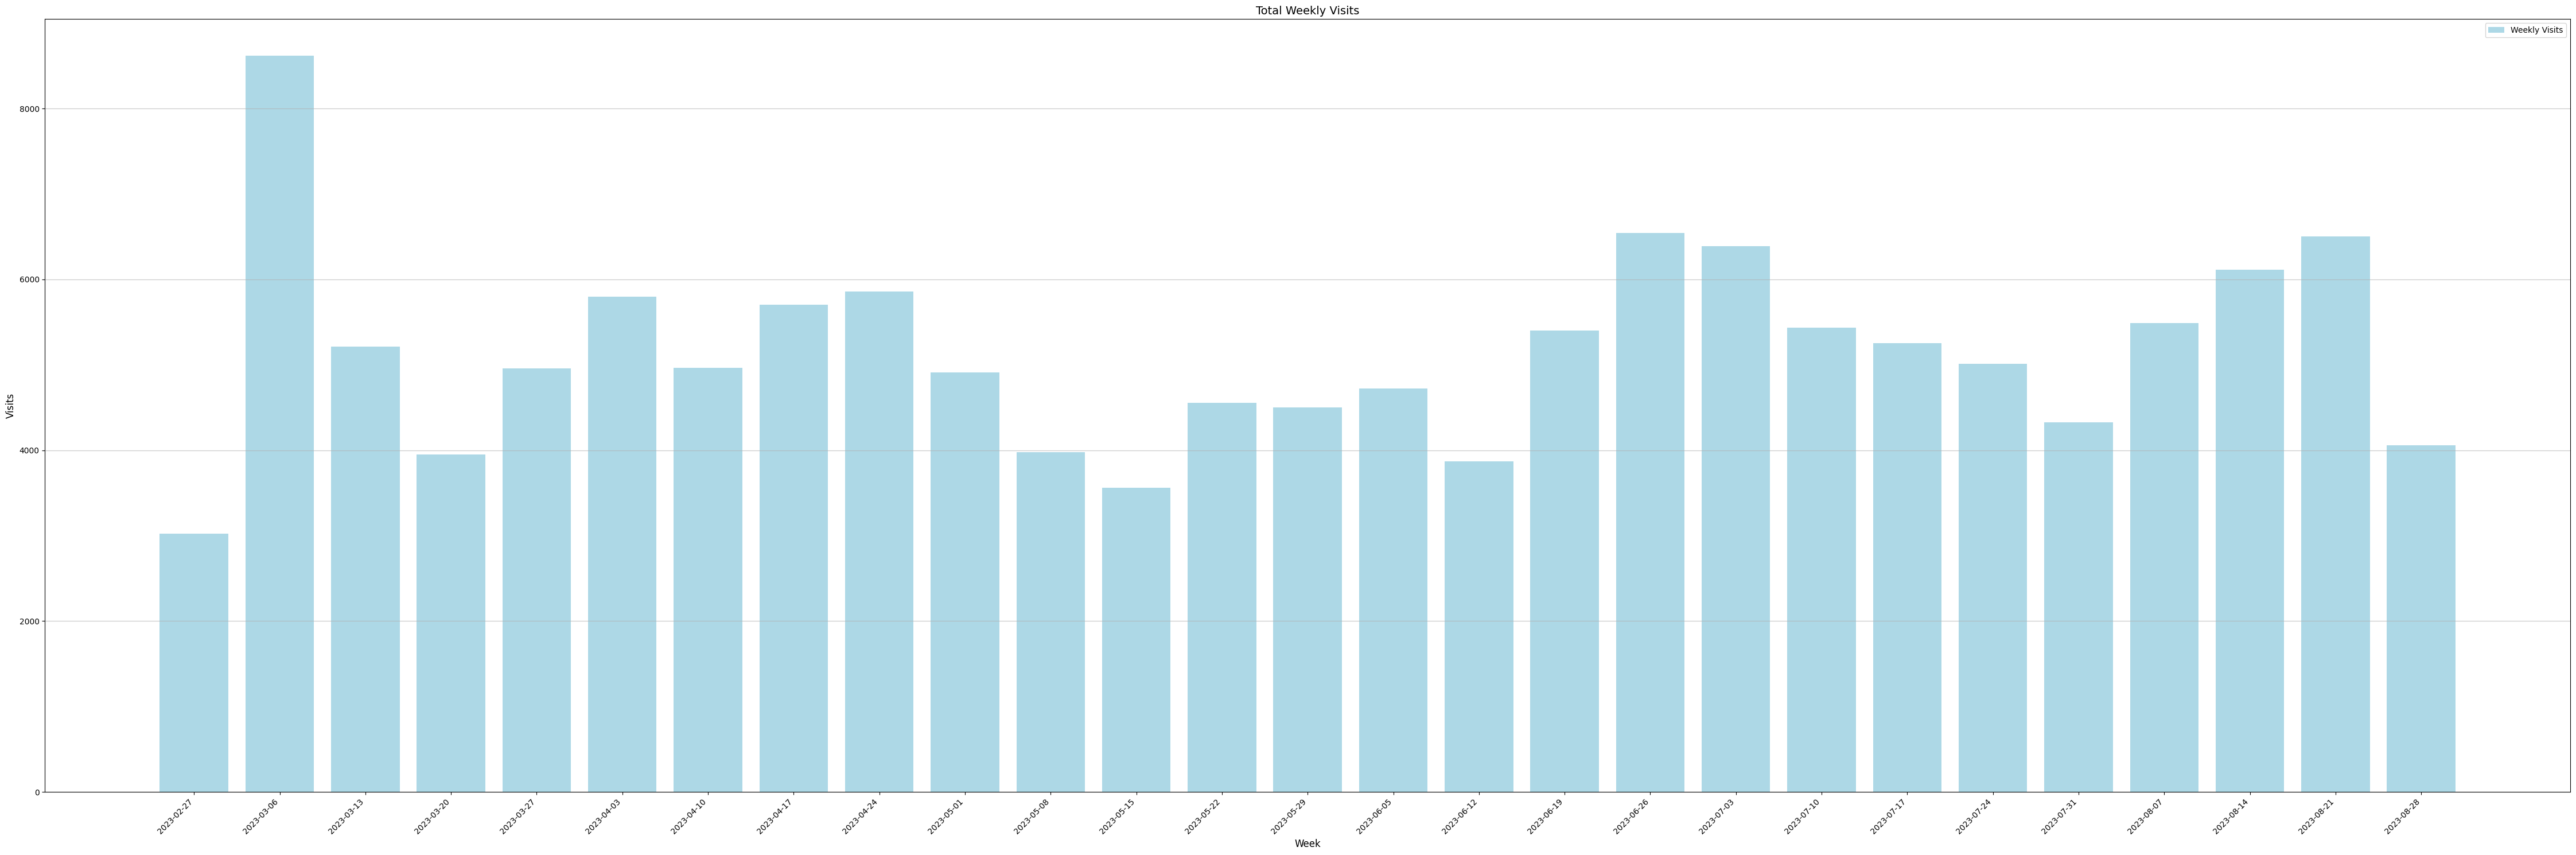

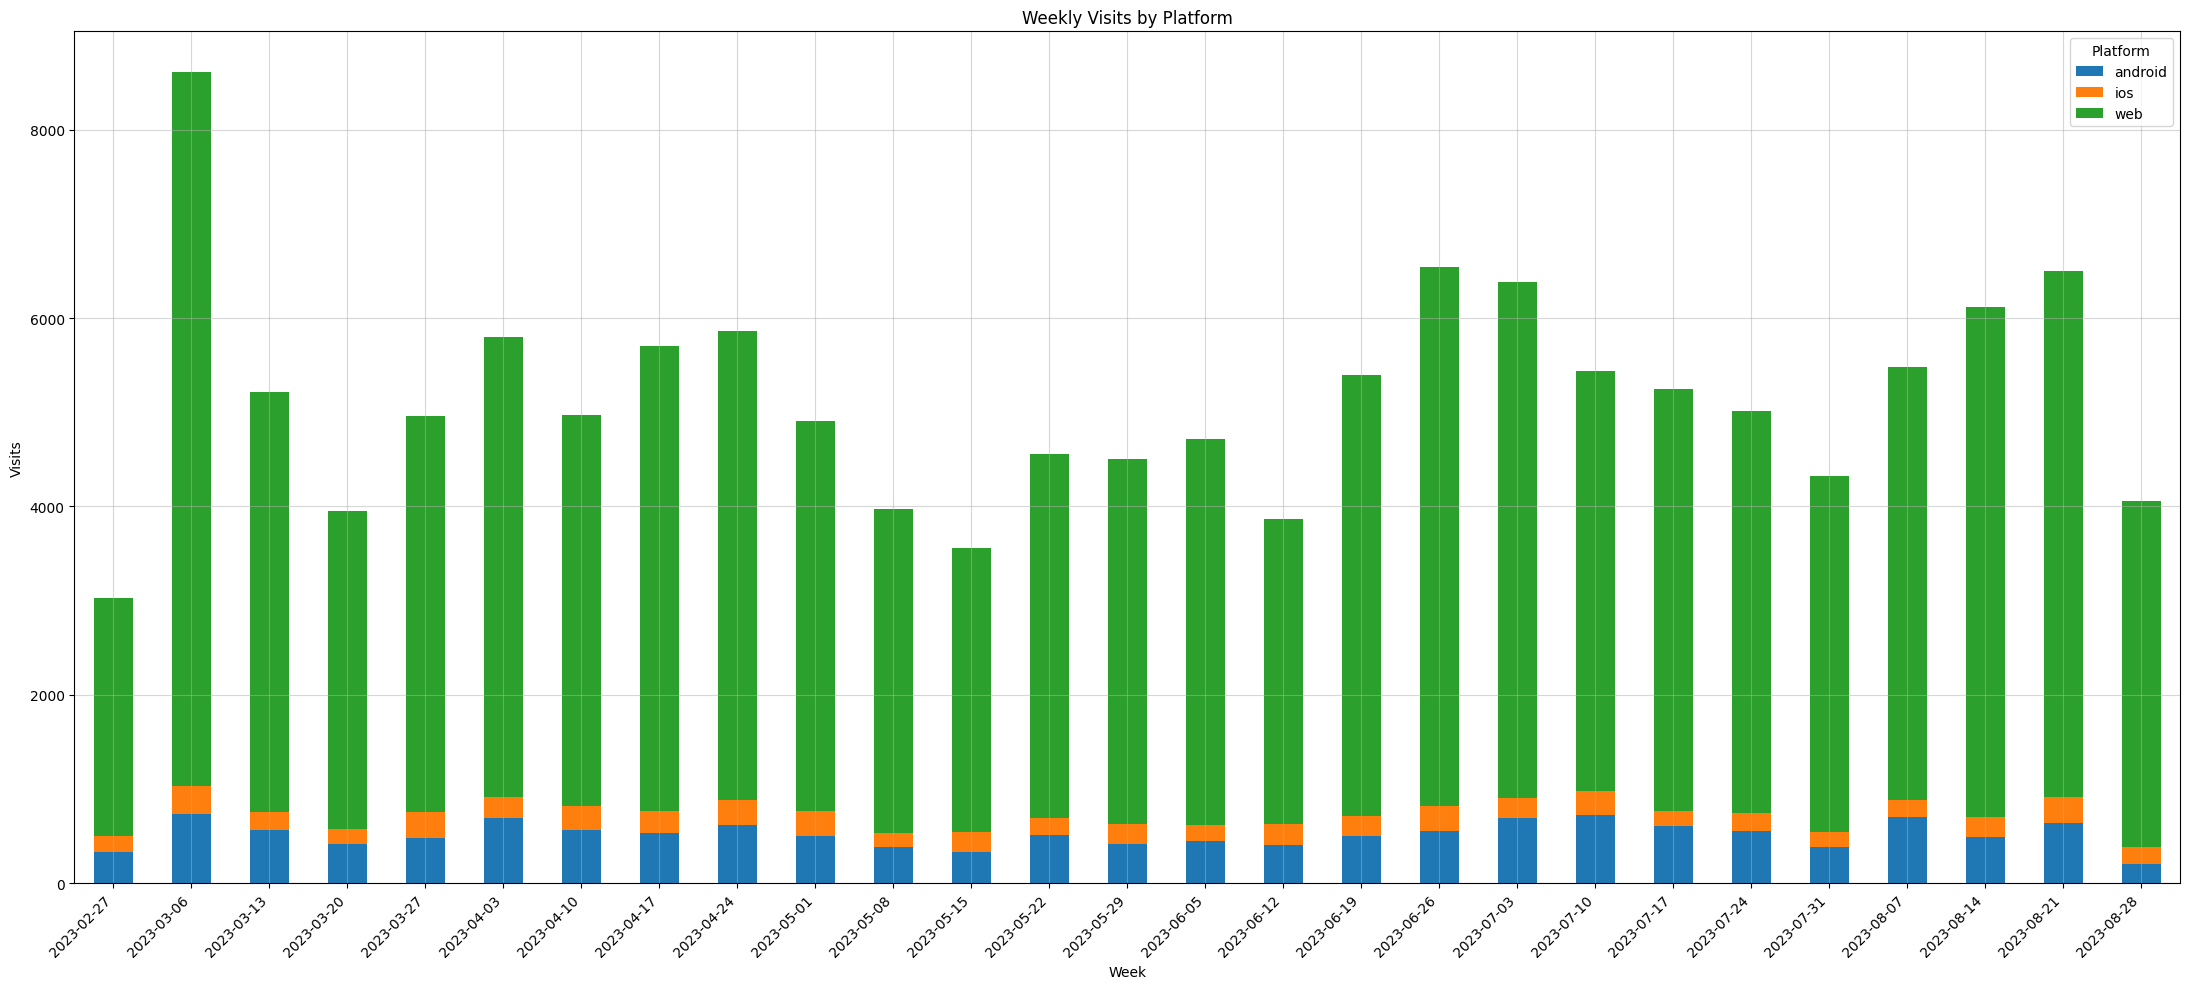

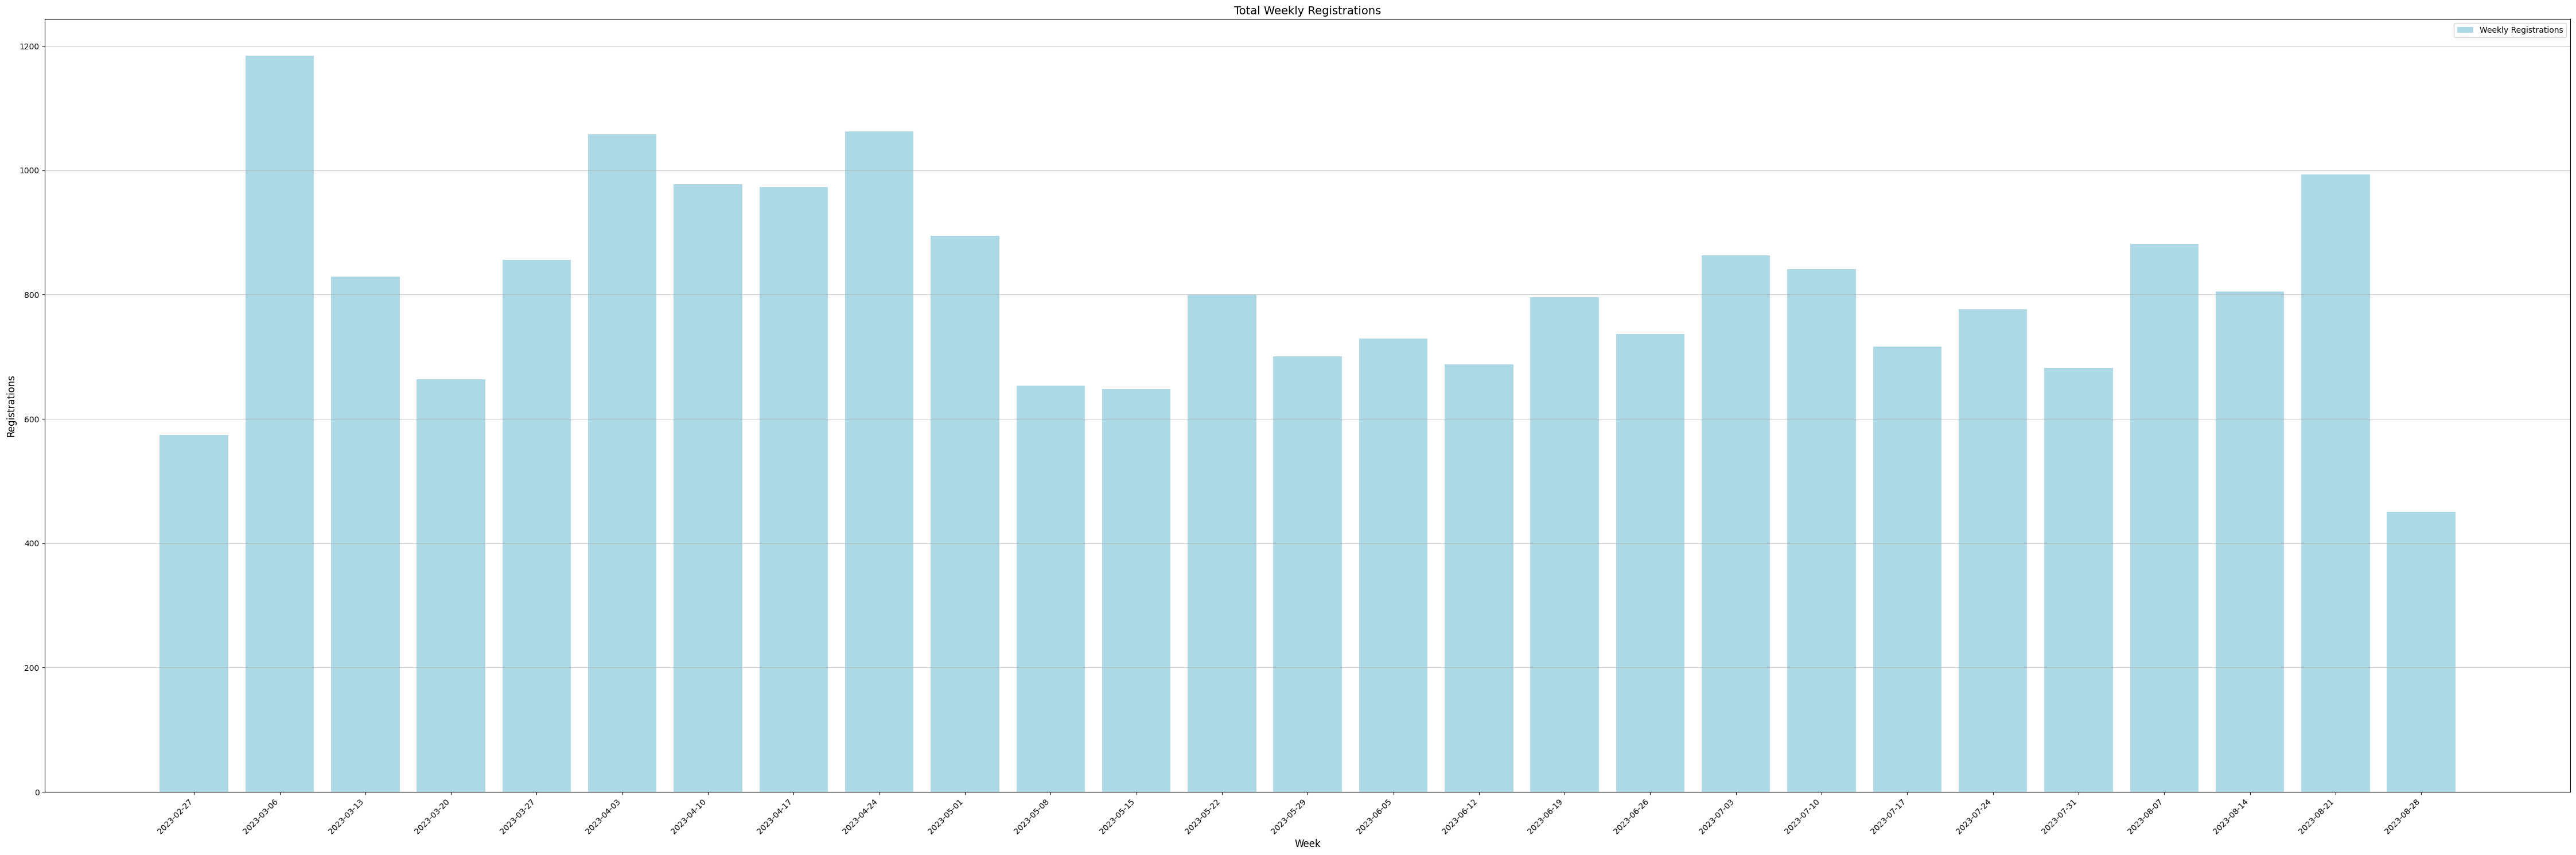

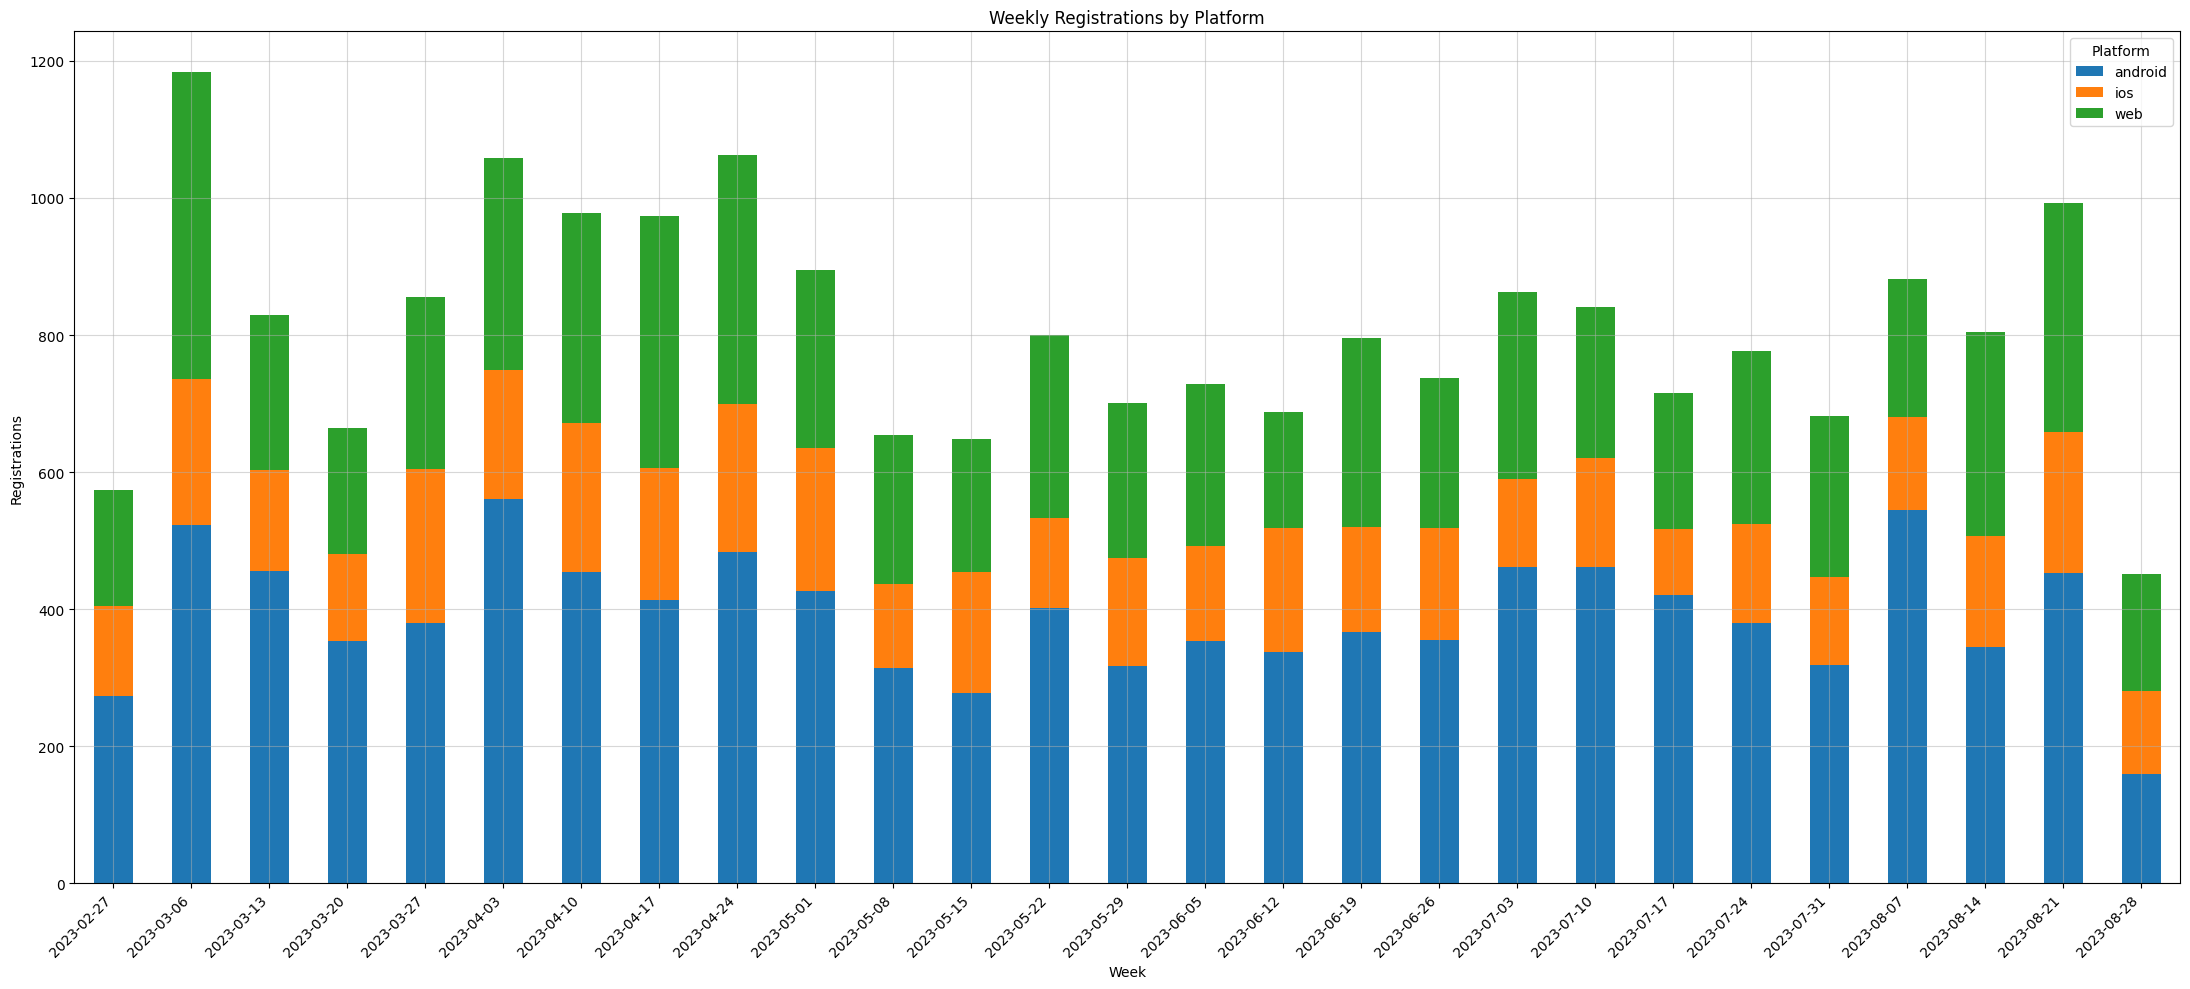

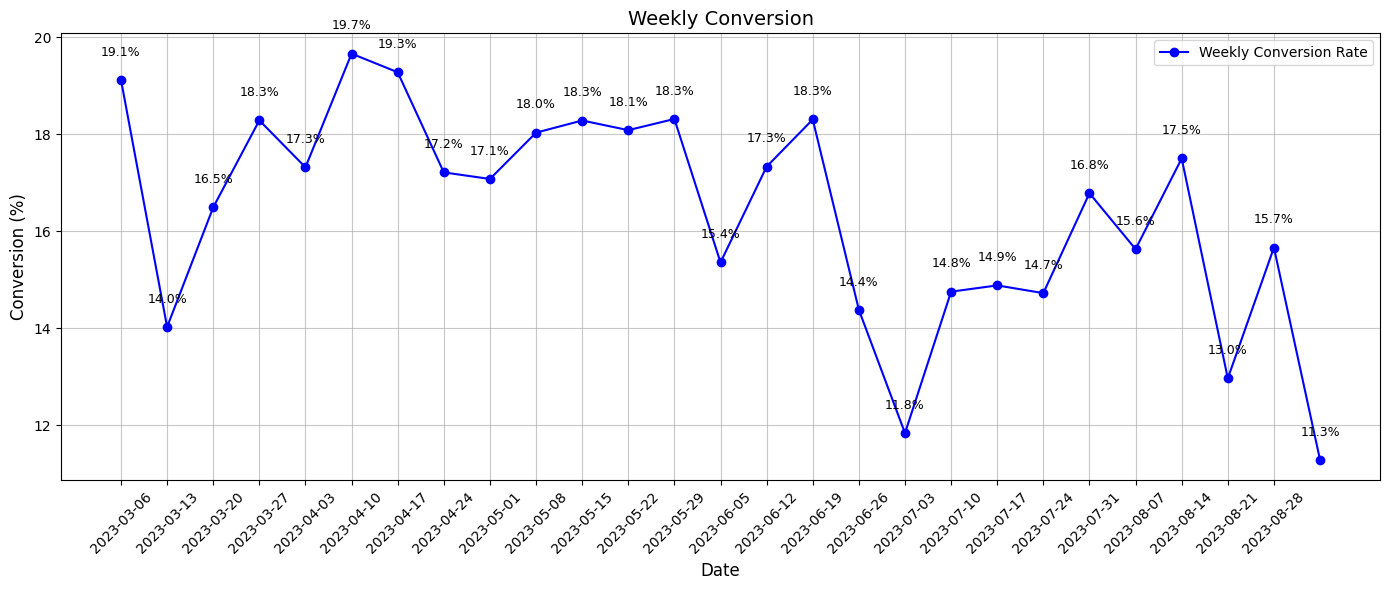

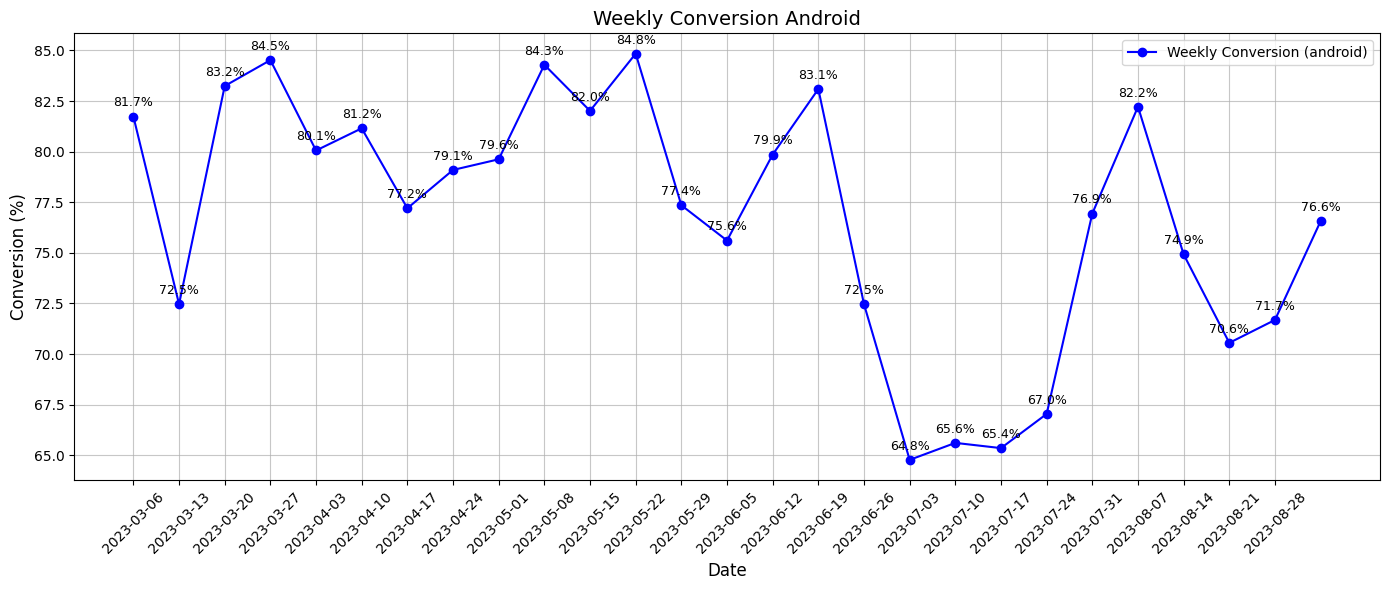

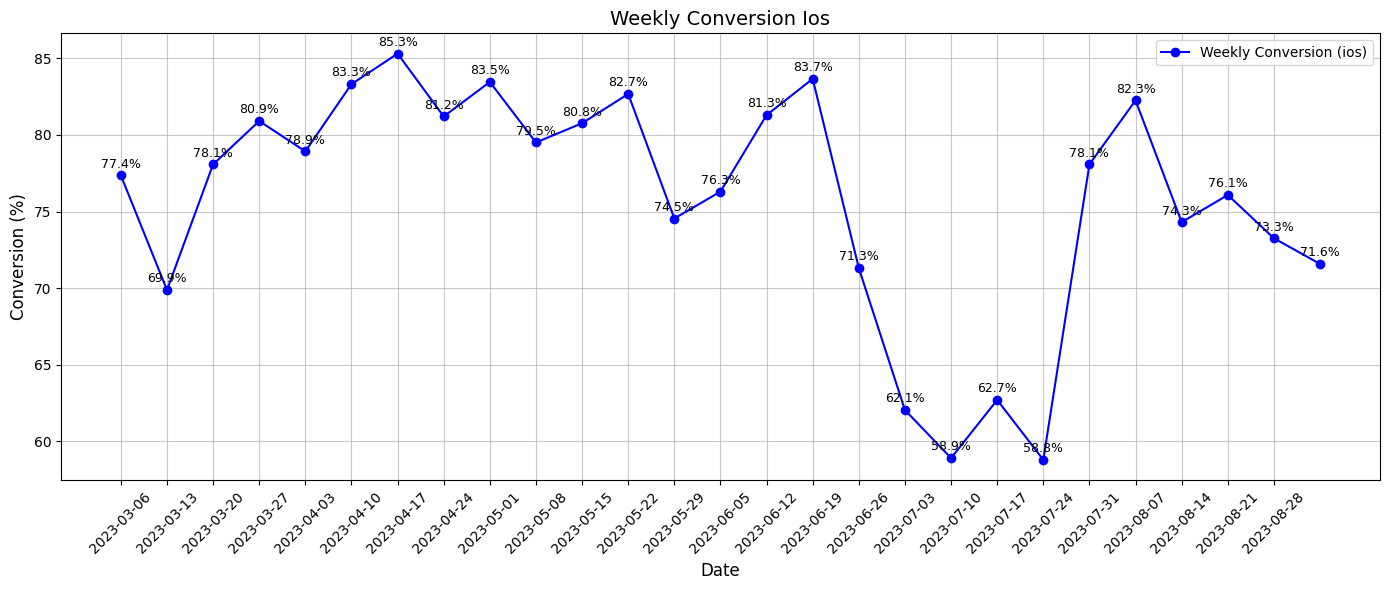

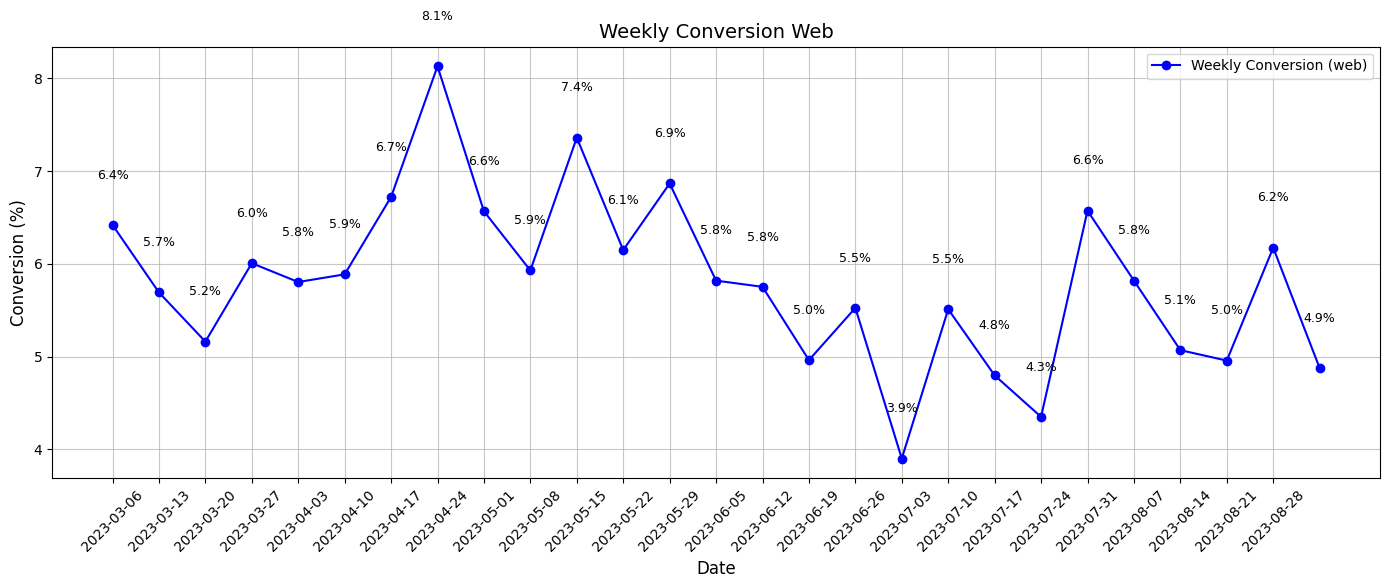

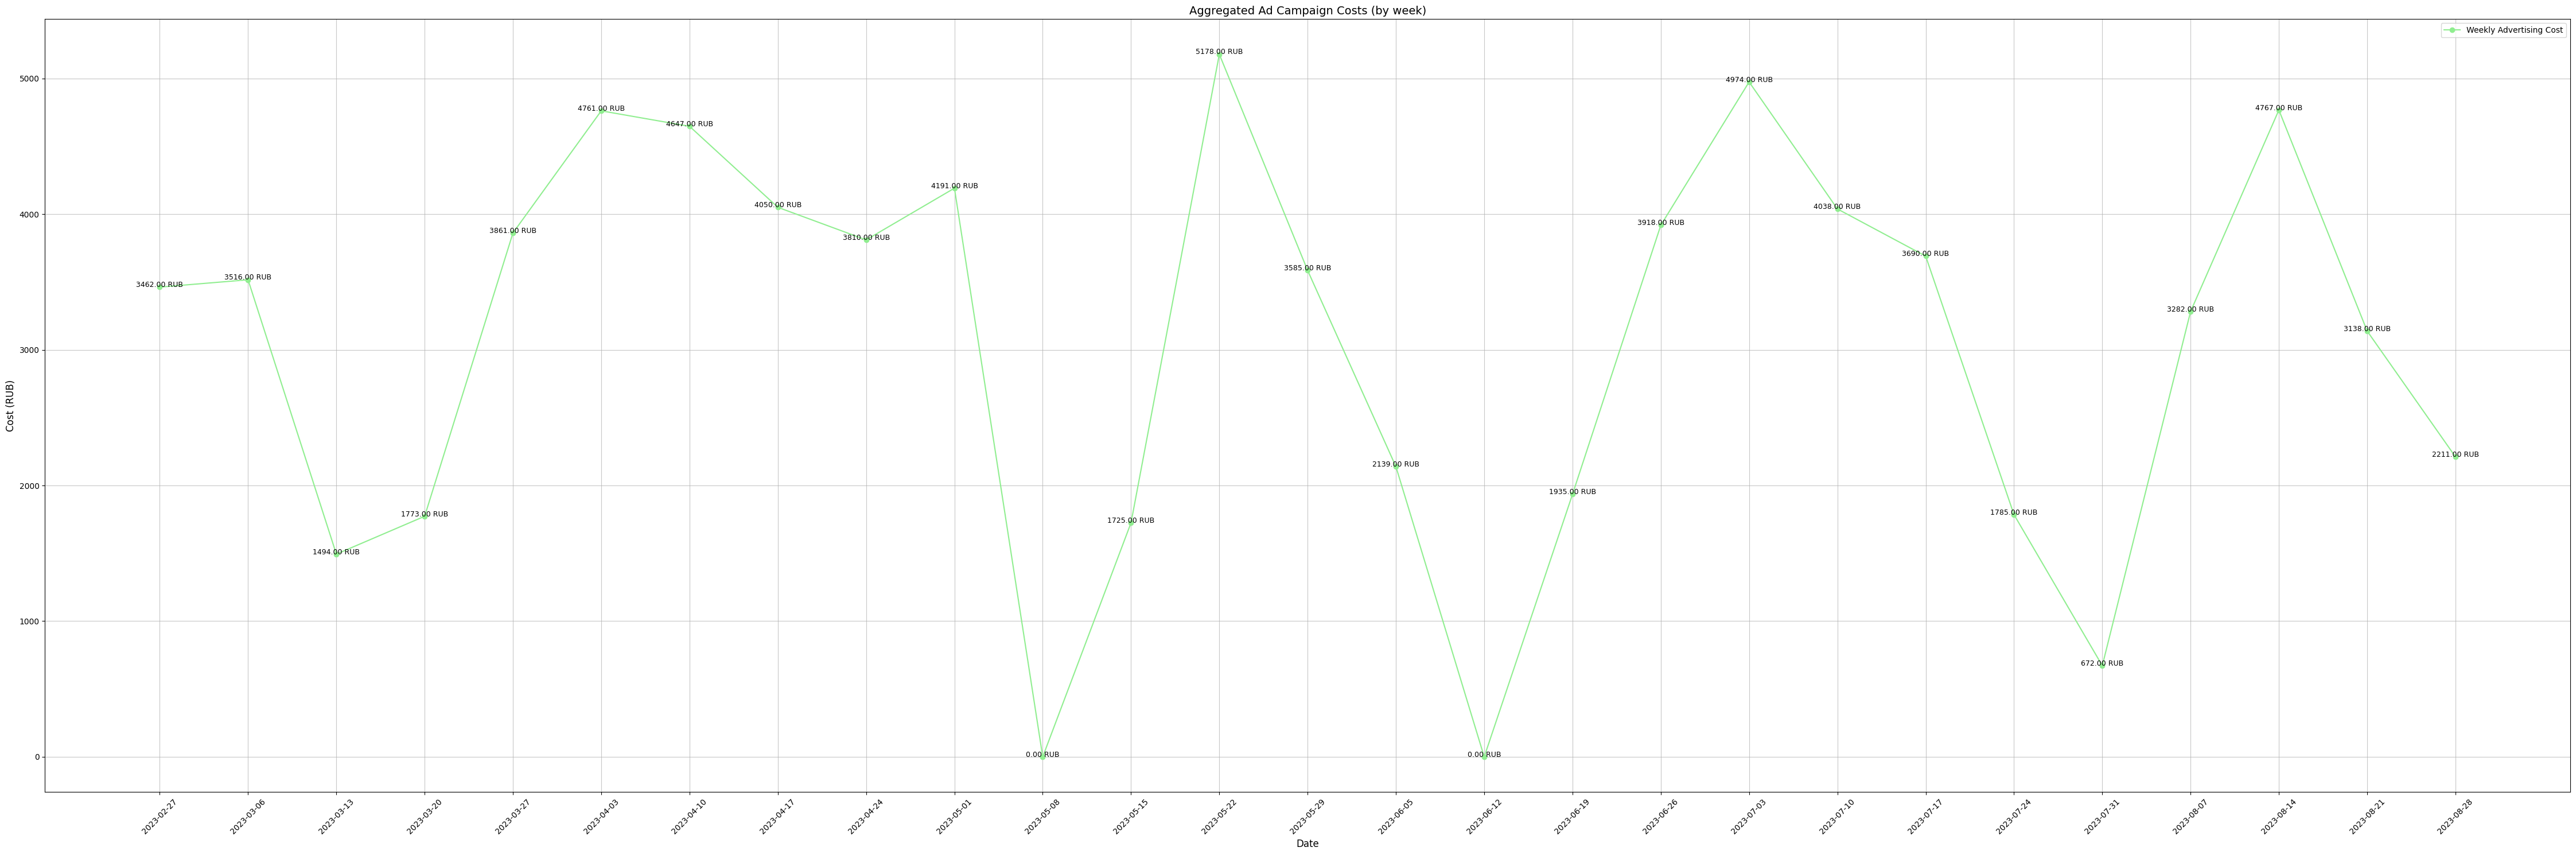

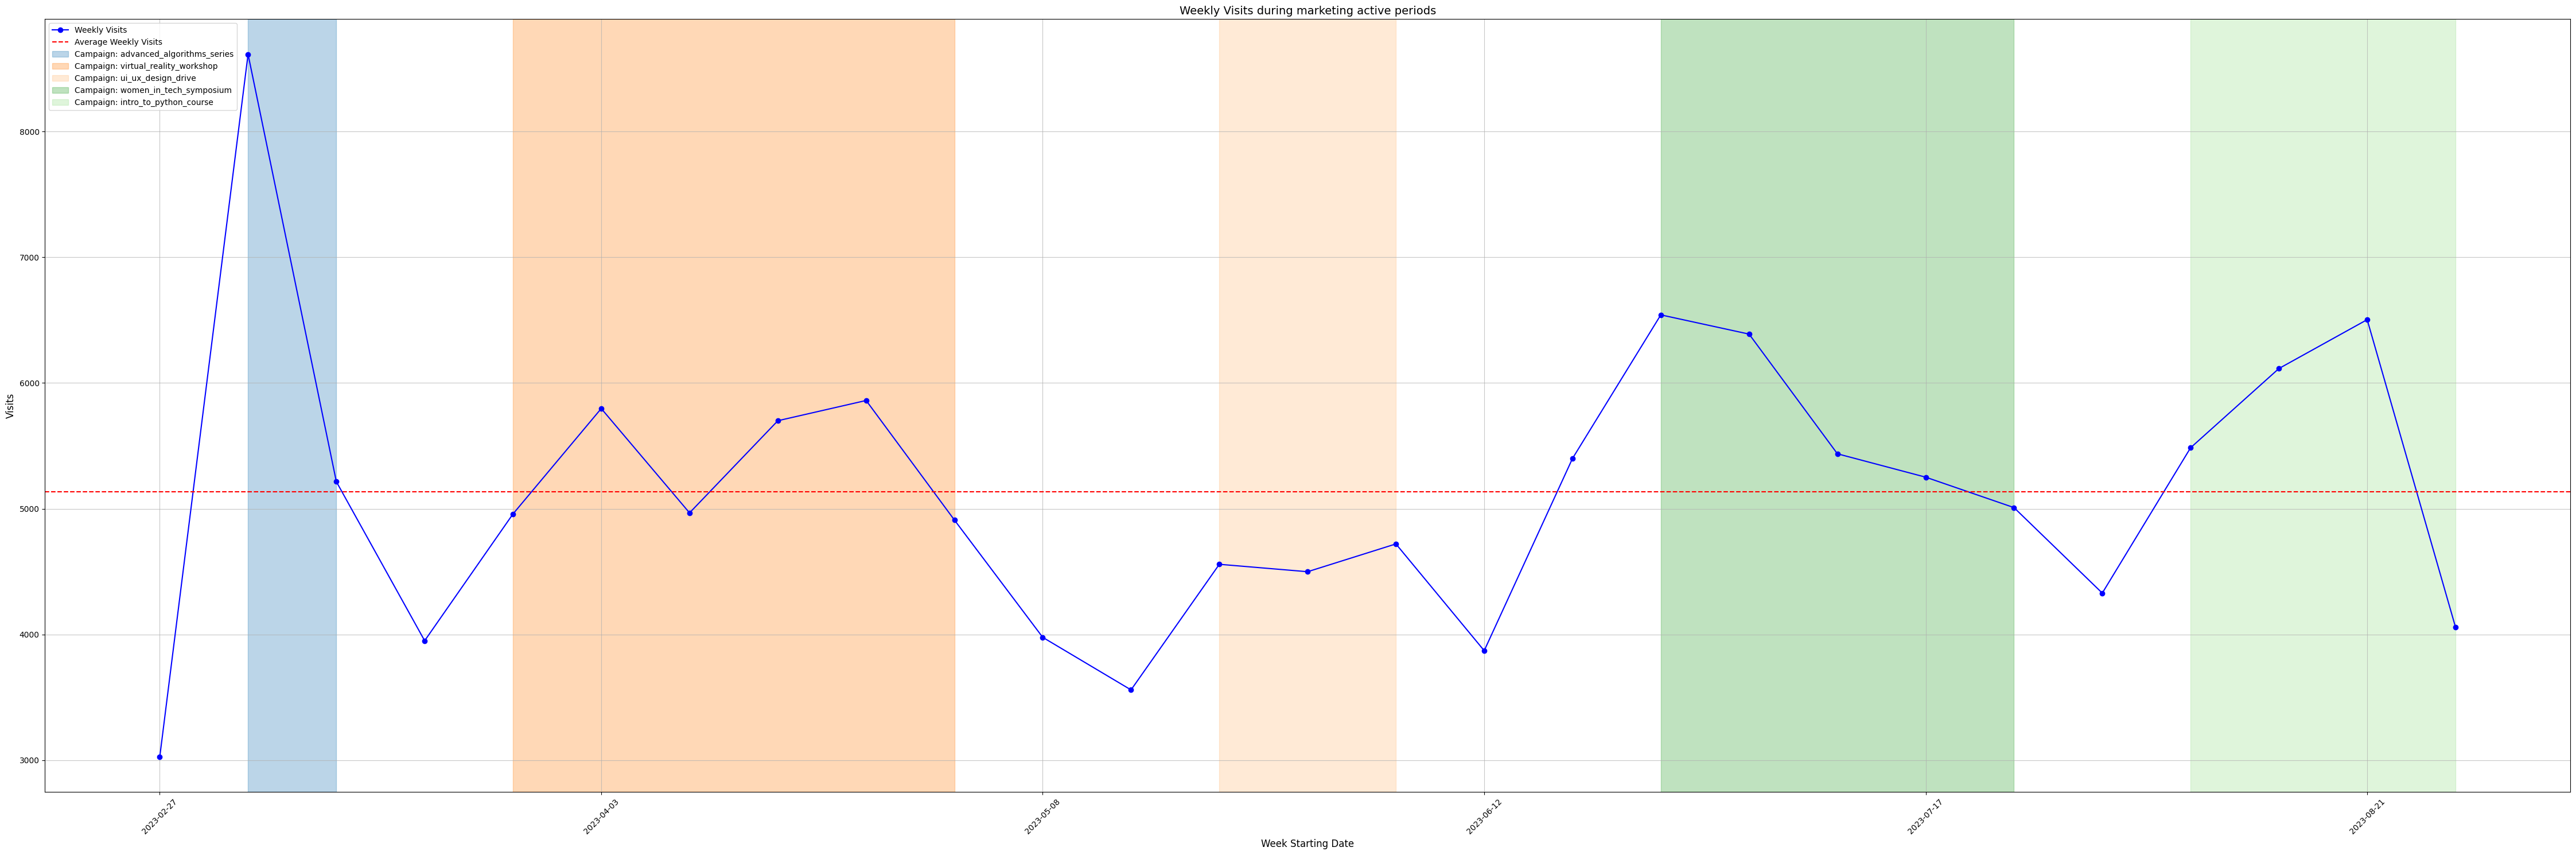

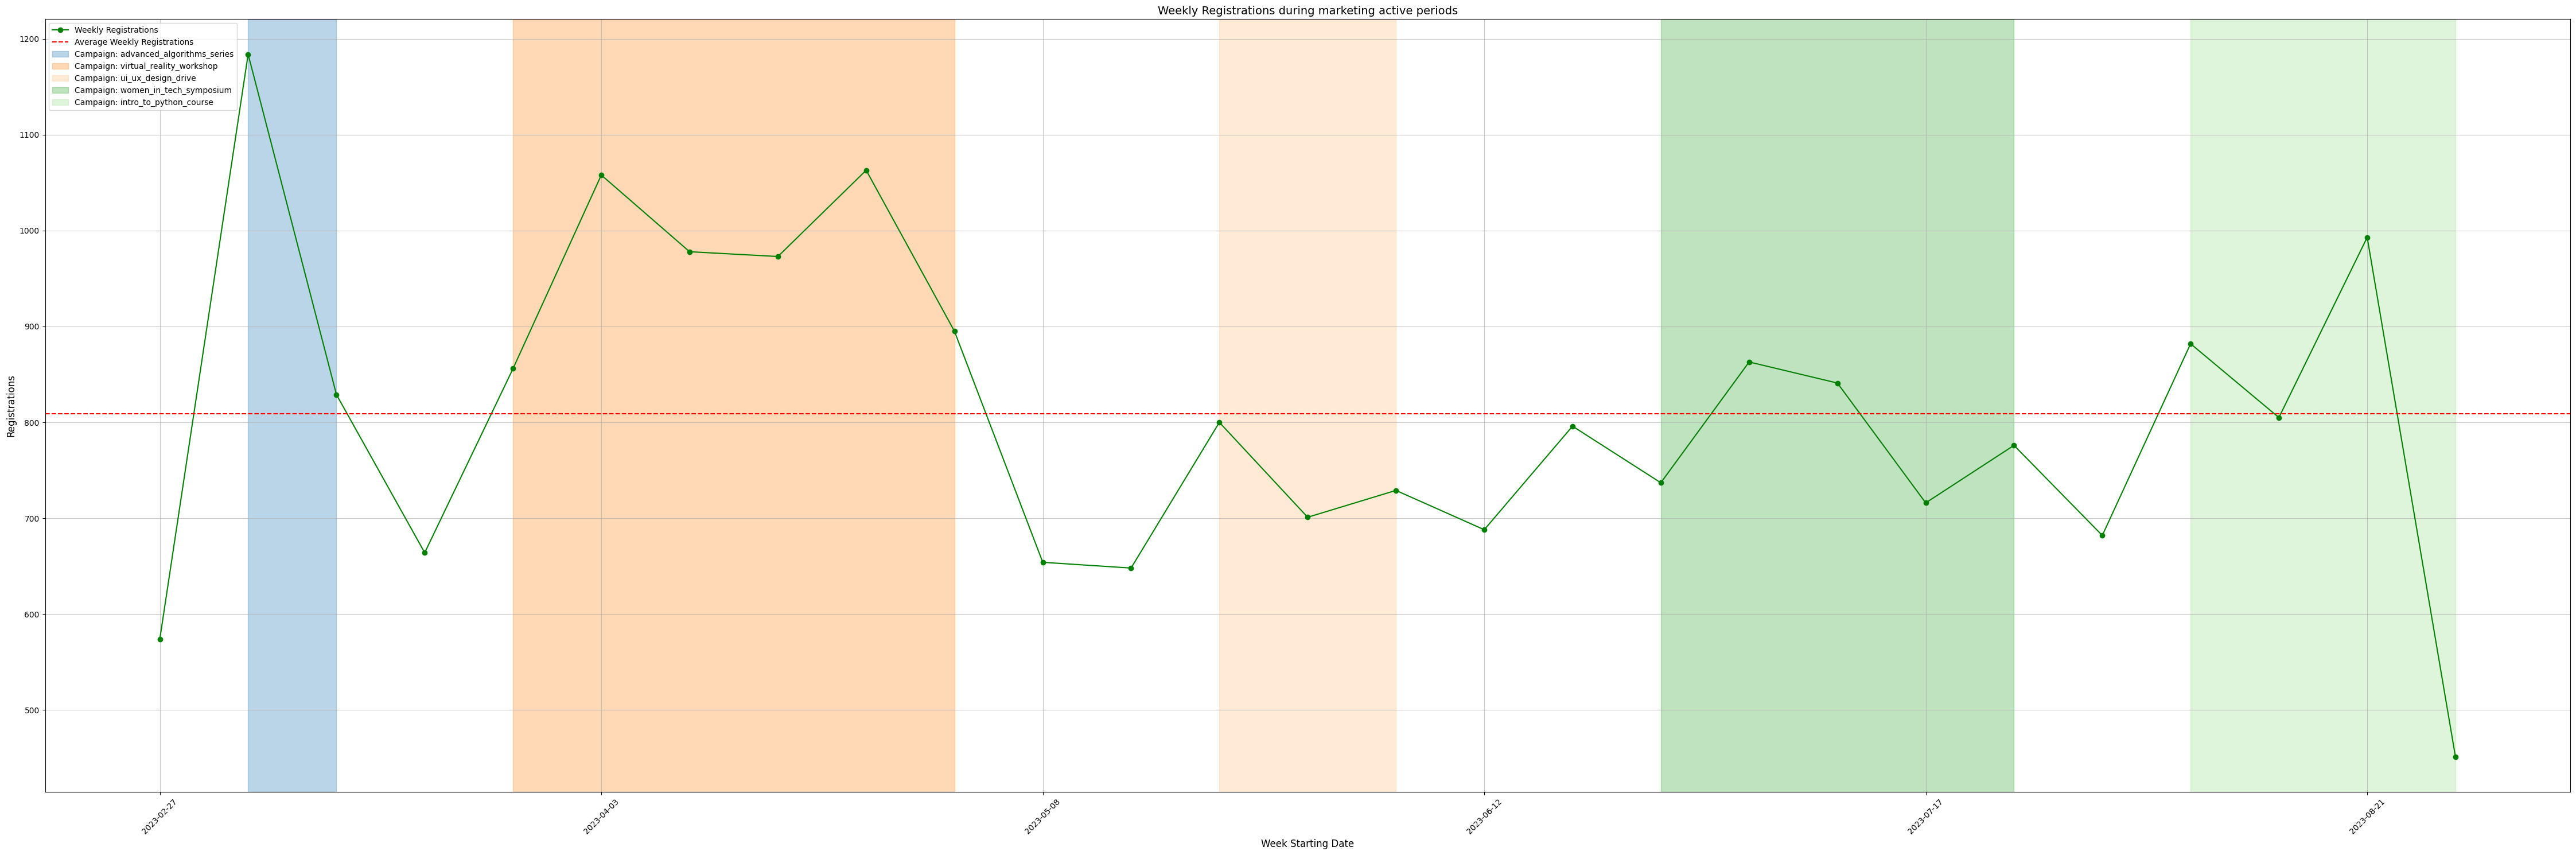

In [9]:
charts()